In [1]:
import numpy as np
import tensorflow as tf
import utils

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
#打开wiki数据集
with open('.//wiki.txt') as f:
    words = utils.preprocess(f.read())  #获得分割后的单词，如果不做 utils.preprocess将得到 26个字母加其他符号
    

In [3]:
print('总的单词数:',len(words))
print('唯一单词数:',len(set(words)))

总的单词数: 16680599
唯一单词数: 63641


In [4]:
# 创建语料库字典，按照文字出现频率编号
word_to_int, int_to_word = utils.create_lookup_tables(words)
int_words = [word_to_int[word] for word in words]


In [6]:
#验证文字编号
print(int_to_word[1])
print(word_to_int['on'])

of
24


In [7]:
#实现Mikolov下采样
from collections import Counter
import random

threshold = 1e-6 #1e-4 到 1e-6之间
word_counts = Counter(int_words) #  Counter({0: 1061396, 1: 593677, 2: 416629, 3: 411764......}
total_count = len(int_words)     # 16680599
freqs = {word: count/total_count for word, count in word_counts.items()} #{0: 0.06363056866243233, 1: 0.035590868169662254.....}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts} #子采样公式

#如果对于当前的计算单词，取一个随机数，当随机数 小于 < 1 - (P抛弃概率) ，则把这个单词作为训练数据。
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
print('训练的单词数为：',len(train_words))
#注意用过滤后的数据训练出来的词向量，依然可以表示所有词汇（权重的数量依旧是总的单词数 * 神经元个数），只是过滤的单词生成的词向量与现有词向量之间在距离上没有什么意义。


训练的单词数为： 1955405


## 创建批

我们想要从目标中获得的 是抓取我们的输入单词周围窗口 $C$. 的单词，通过get_wordx_labely函数实现。它通过传入一个单词 然后在窗口中你抓取它周围的单词，周围的单词数是随机生成的Rand_No ，在1到窗口+1之间


In [8]:
def get_wordx_labely(words, idx, window_size=5):
    ''' 给予窗口，对words中的某个idx的word(X)，给出周围随机数量个单词(Y). '''
    #产生一个1 到 窗口+1 的随机数。
    Rand_No = np.random.randint(1, window_size+1)
    
    #单词idx如果是3，Rand_No=2，  就取 3前两个，2两个单词  start= 3-2=1,stop=3+2=5 。
    startidx = idx - Rand_No if (idx - Rand_No) > 0 else 0
    stopidx =  idx + Rand_No
    labely_words = set(words[startidx:idx] + words[idx+1:stopidx+1])
    
    
    return list(labely_words)

In [18]:
#验证get_wordx_labely
print(words[0:7])
print(set(words[1:3] + words[4:6])) #效果为Rand_No=2，idx=3
print(len(words))

get_wordx_labely(words,3)

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse']
{'as', 'term', 'of', 'originated'}
16680599


['as', 'term']

In [19]:
#定义获取batch,batch_size是从words 中获得的一份列表，基于每个batch的 word 生成 x ，和 y
def get_batches(words, batch_size, window_size=5):
    ''' 生成器生成，word batches ， tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # 完整batch
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_wordx_labely(batch, i, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    


In [20]:
########验证BATCH 固定设置R=2########
def get_wordx_labely(words, idx, window_size=5):
    ''' 给予窗口，对words中的某个idx的word(X)，给出周围随机数量个单词(Y). '''
    #产生一个1 到 窗口+1 的随机数。
    Rand_No = 2
    
    #单词idx如果是3，Rand_No=2，  就取 3前两个，2两个单词  start= 3-2=1,stop=3+2=5 。
    startidx = idx - Rand_No if (idx - Rand_No) > 0 else 0
    stopidx =  idx + Rand_No
    labely_words = set(words[startidx:idx] + words[idx+1:stopidx+1])
    
    
    return list(labely_words)

#########验证BATCH##########################
print('batch_size=4 ，window_size=5' ,'考察前两批')
batch_size=4
n_batches =len(words)//batch_size
print('n_batches数为：',n_batches)


# 完整batch
words = words[:n_batches*batch_size]


noi=0
window_size=5
for idx in range(0, len(words), batch_size):
    noi=noi+1
    print('第',noi,'批')
    print('idx=',idx)
    x, y = [], []
    batch = words[idx:idx+batch_size]
    print('batch=',batch ,'len(batch)=',len(batch))
    
    
    for i in range(len(batch)):
        batch_x = batch[i]
        print('batch_x=',batch_x)
        batch_y = get_wordx_labely(batch, i, window_size)
        print('batch_y=',batch_y)
        y.extend(batch_y)
        x.extend([batch_x]*len(batch_y))
    print('x=',x ,'y=',y) 
    if noi == 1 :
            break

        





batch_size=4 ，window_size=5 考察前两批
n_batches数为： 4170149
第 1 批
idx= 0
batch= ['anarchism', 'originated', 'as', 'a'] len(batch)= 4
batch_x= anarchism
batch_y= ['as', 'originated']
batch_x= originated
batch_y= ['anarchism', 'as', 'a']
batch_x= as
batch_y= ['anarchism', 'a', 'originated']
batch_x= a
batch_y= ['as', 'originated']
x= ['anarchism', 'anarchism', 'originated', 'originated', 'originated', 'as', 'as', 'as', 'a', 'a'] y= ['as', 'originated', 'anarchism', 'as', 'a', 'anarchism', 'a', 'originated', 'as', 'originated']


In [21]:
#input 是我们的输入单词编码。
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



embedding 矩阵的大小为：单词数 X 隐藏层神经元个数(embedding 特征数) 。假设有100个单词，10个神经元，将对应100 X 10 的矩阵。训练好以后，当传人一个词对应的编号，将返回一个位于矩阵中对应行的向量。embedding初始可以是 100-300之间值。

In [22]:
n_vocab = len(int_to_word)
n_embedding = 200 # embedding 特征数，也就是 隐藏层神经元个数 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) #一般初始化embedding tensor为 -1,1之间的随机数
    #embedding的形状为=(63641, 200)
    
    #写summary
    tf.summary.histogram('embeding_w',embedding)
   
    
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [23]:
#验证embedding_lookup ，0-9 10个数原来每个数是10个特列列的ONE-HOT，现在变成2个特征
import tensorflow as tf
import numpy as np

test_embedding_w = tf.Variable(tf.random_uniform((10,2), -1, 1))
idx = np.array([0,1, 2,3,4,5,6,7,8,9])
out = tf.nn.embedding_lookup(test_embedding_w, idx)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(out))
    
    #-------------下次传人  “1”----------------#
    print(sess.run(tf.nn.embedding_lookup(test_embedding_w, np.array([0]))))

[[ 0.06714272 -0.47153854]
 [ 0.39632273 -0.90652037]
 [ 0.81146526  0.08813095]
 [ 0.35289598 -0.04644632]
 [ 0.96639776  0.31767893]
 [-0.21888947  0.27795005]
 [ 0.32654953  0.62284446]
 [ 0.81638765 -0.88932252]
 [ 0.57390594 -0.49690986]
 [-0.3963697   0.10825372]]
[[ 0.06714272 -0.47153854]]


## 负采样Negative sampling 训练技巧



现实中由于编码向量有上万个。对于每个单元要使用 softmax 进行预测，但是真实的输出也就是正结果只有一个，其他的为负结果。这样训练起来非常的慢。因此我们可以仅对负结果的一个非常小的子集取样来计算损失，从而获得损失的近似值。这样在更新权重时，我们不是更新所有的权重 ，而是仅更新正的那些权重，和小部分负样本对应的权重。这种技巧叫负采样。tensorflow直接提供一个 tf.nn.sampled_softmax_loss 函数完成负采样



In [24]:
# 设置负样本为100
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    #############summary###################
    tf.summary.histogram('softmax_w',softmax_w)
    merged=tf.summary.merge_all()
    
    ############summary###################
    # 计算损失
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [29]:
import os
epochs = 5
batch_size = 512
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()
    
    #     logits=tf.add(tf.matmul(embedding,tf.transpose(softmax_w)),softmax_b)
    #     outy=tf.nn.softmax(logits=logits)
    #     lastout=tf.arg_max(outy,1)
    #     print(lastout) 


    #可选规范化embedding
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True)) 
    normalized_embedding = embedding / norm
    
    

with tf.Session(graph=train_graph) as sess:
    iter_no = 0
    loss = 0
    initv=tf.global_variables_initializer()
    ##################################
    summary_writer = tf.summary.FileWriter(logdir='d:\\tensorlog\\',graph=train_graph)
    summary_writer.add_graph(sess.graph)
    
    

    sess.run(initv)

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)

        for x, y in batches:

            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)

            loss += train_loss

            if iter_no % 100 == 0: 
                print('第：',e, '轮 第 ',iter_no,' 批 loss为：',loss)
                loss = 0
                ############################
                merged_out=sess.run(merged)
                summary_writer.add_summary(merged_out,iter_no)
                ###########################



            iter_no += 1
            break
          
    save_path = saver.save(sess, "d:\\tensorlog\\wiki.ckpt")

    normed_embedding = sess.run(normalized_embedding)

第： 1 轮 第  0  批 loss为： 5.30805063248


In [30]:
#恢复数据
with train_graph.as_default():
    saver = tf.train.Saver()
    


with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('d:\\tensorlog'))
    embed_out = sess.run(embedding)
    
print('训练后矩阵形状为:',embed_out.shape)

print('训练后矩阵形状为:',embed_out[0:2,:])

训练后矩阵形状为: (63641, 200)
训练后矩阵形状为: [[ 0.73052943  0.91380221  0.77104563  0.87625831 -0.47368097 -0.7763052
  -0.30299705  0.45957038 -0.15193579 -0.03052874  0.67169029  0.22647841
  -0.60843015  0.21916698 -0.04636357  0.68149662  0.74498487  0.40404162
   0.46941578 -0.18080074 -0.90756536 -0.89074087 -0.18594158 -0.33434036
   0.7771014   0.26212966 -0.07849427  0.44856471 -0.88894039 -0.30359697
  -0.18063986 -0.28244576 -0.70551449  0.20099895  0.42131329 -0.00417768
  -0.53111529  0.68437856 -0.12798233 -0.74158949  0.12696299  0.725555
  -0.62966889 -0.58021194 -0.02607774 -0.95092708  0.97122848  0.00698642
   0.31060308 -0.04800085  0.16819359 -0.49154779 -0.7017312  -0.03997652
  -0.14549711 -0.28761625  0.020745   -0.11587438  0.9314338  -0.76745319
  -0.39148337  0.77269942 -0.55358368 -0.10513102 -0.82035929  0.31001243
   0.71661019 -1.00143182  0.54216647 -0.15448983  0.27705395 -0.11806997
  -0.05177798 -0.67204458 -0.20675051 -0.46410245  0.46553457  0.53534108
  -0.255

## 降维显示向量


In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

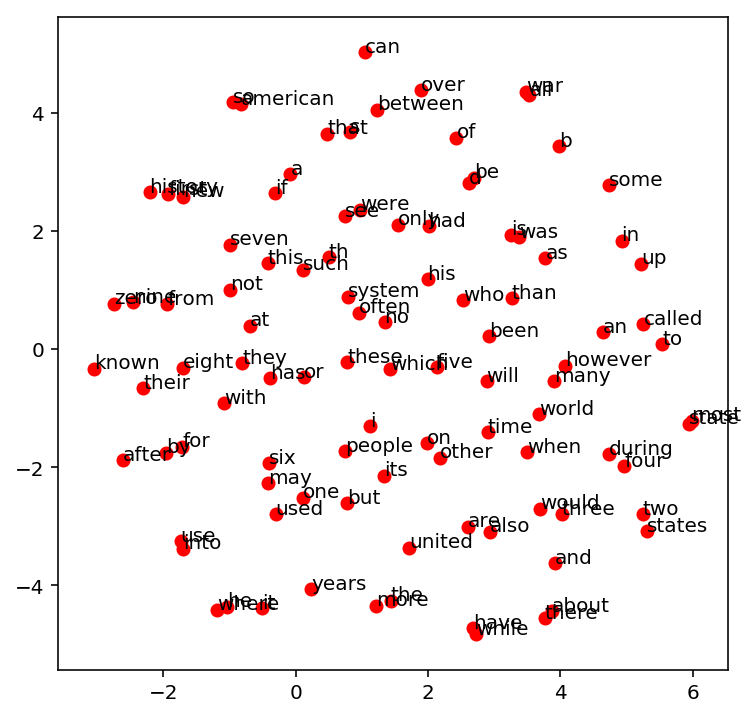

In [33]:
test_words = 100
tsne = TSNE()
embed_tsne = tsne.fit_transform(normed_embedding[:test_words, :]) #对规范化的embedding做TSNE处理
#print(embed_tsne)
plt.subplots(figsize=(6, 6)) #画布长宽
for idx in range(test_words):
    plt.scatter(*embed_tsne[idx, :], color='red') #2维度散点图
    plt.annotate(int_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]))#写入文字

In [34]:
#验证embedding_lookup ，0-9 10个数原来每个数是10个特列列的ONE-HOT，现在变成2个特征
import tensorflow as tf
import numpy as np

embedding = tf.Variable(tf.random_uniform((10,2), -1, 1))
idx = np.array([0,1, 2,3,4,5,6,7,8,9])
out = tf.nn.embedding_lookup(embedding, idx)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(out))
    
    #-------------下次传人1----------------#
    print(sess.run(tf.nn.embedding_lookup(embedding, np.array([0]))))

[[ 0.51695013 -0.14181781]
 [-0.09906435  0.72526383]
 [-0.90926743  0.33294415]
 [-0.03497219  0.85729074]
 [-0.57292962 -0.25392818]
 [-0.92012215  0.8126533 ]
 [-0.13679934 -0.71009088]
 [ 0.8187623   0.43121004]
 [-0.33569741  0.73010278]
 [ 0.58891797 -0.75244498]]
[[ 0.51695013 -0.14181781]]
